This scritp aims to solve the Grad-Shafranov equation modelling the plasma equilibrium in an axisymmetrical (cylindrical) system.
It shall constitute the benchmark or miniature code for the actual project behind, which goal is to develop a module for ALYA (BSC-Marenostrum)
computing the plasma equilibrium.

READ INPUT FILES...
     -> READ MESH DATA FILES...Done!
     -> READ EQUILI DATA FILE...Done!
Done!
INITIALIZATION...
     -> COMPUTE INITIAL GUESS...Done!
     -> INITIALISE LEVEL-SET...Done!
     -> INITIALISE ELEMENTS...Done!
     -> CLASSIFY ELEMENTS...Done!
     -> INITIALISE ELEMENTAL PHI VALUES...Done!
     -> FIND BOUNDARY EDGES...Done!
     -> COMPUTE BOUNDARY NORMALS...Done!
     -> APPROXIMATE INTERFACE...Done!
     -> COMPUTE INTERFACE NORMALS...Done!
     -> COMPUTE NUMERICAL INTEGRATION QUADRATURES...Done!
     -> COMPUTE INITIAL VACUUM VESSEL BOUNDARY VALUES PHI_B...Done!
Done!
START ITERATION...
OUTER ITERATION = 1 , INNER ITERATION = 1
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


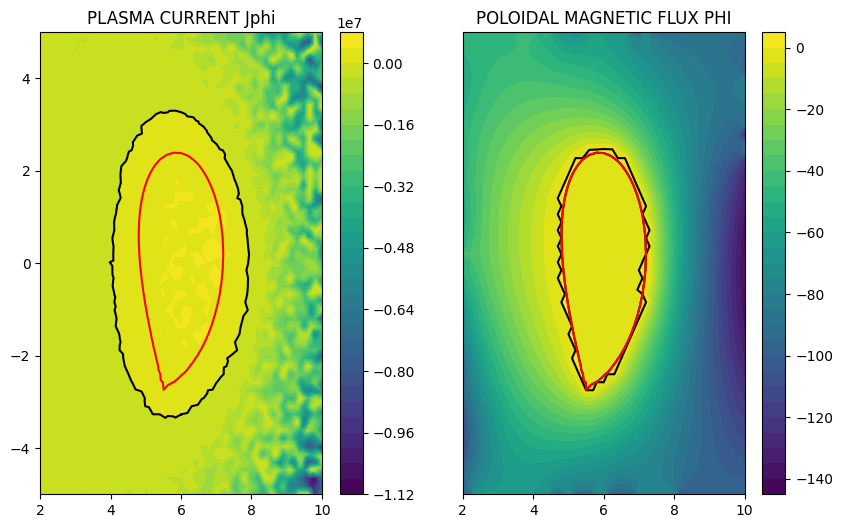

OUTER ITERATION = 1 , INNER ITERATION = 2
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


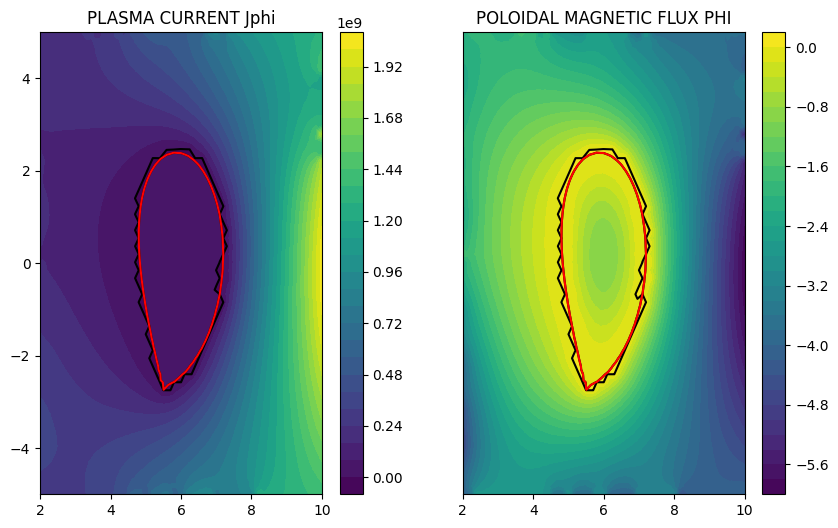

OUTER ITERATION = 1 , INNER ITERATION = 3
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


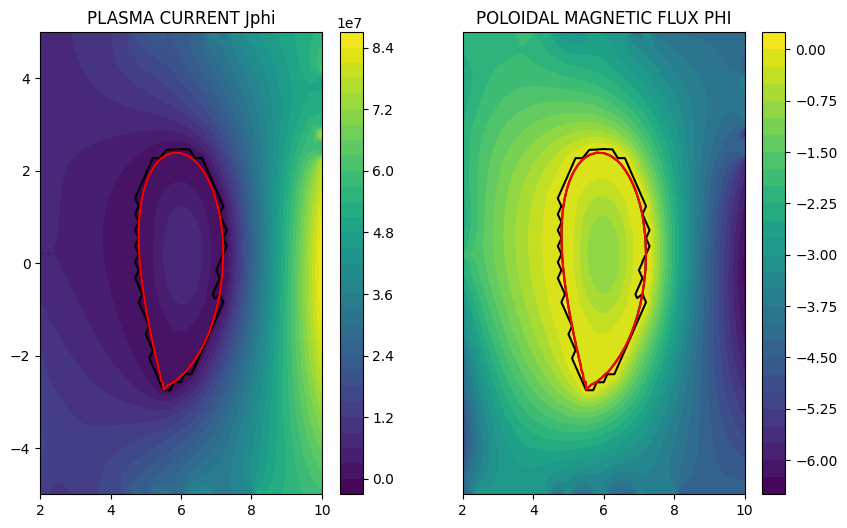

OUTER ITERATION = 1 , INNER ITERATION = 4
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


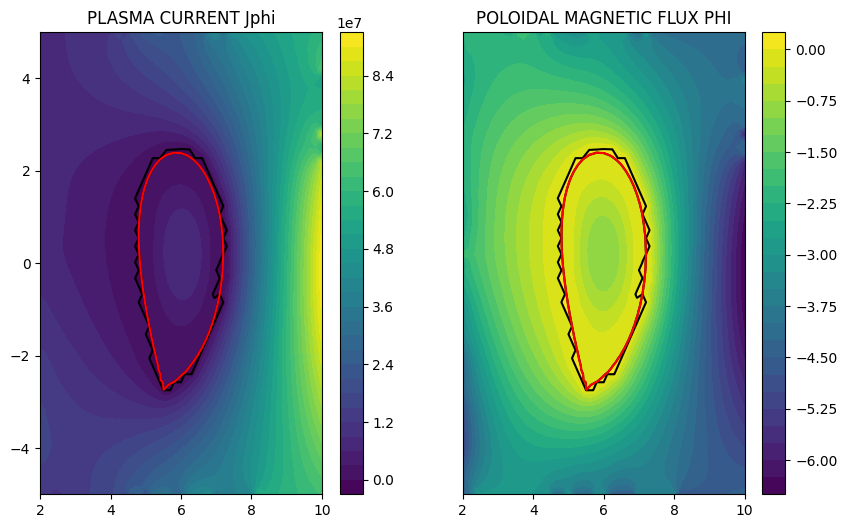

OUTER ITERATION = 1 , INNER ITERATION = 5
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


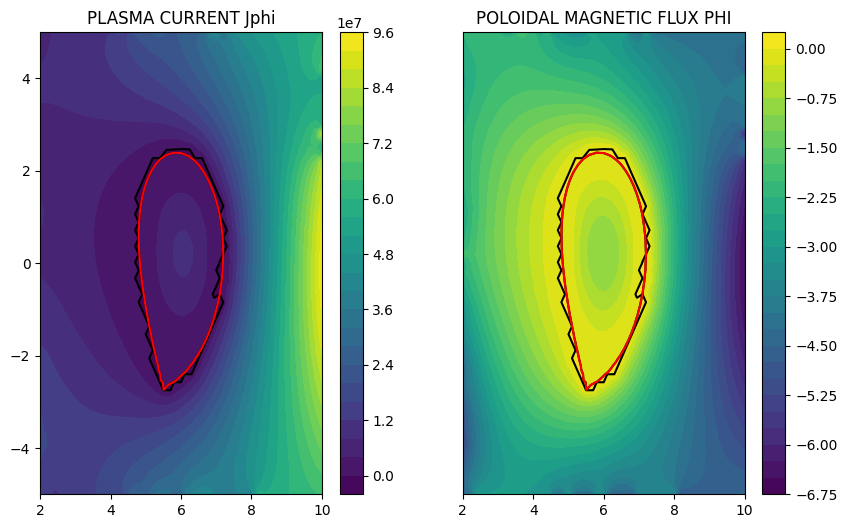

OUTER ITERATION = 1 , INNER ITERATION = 6
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


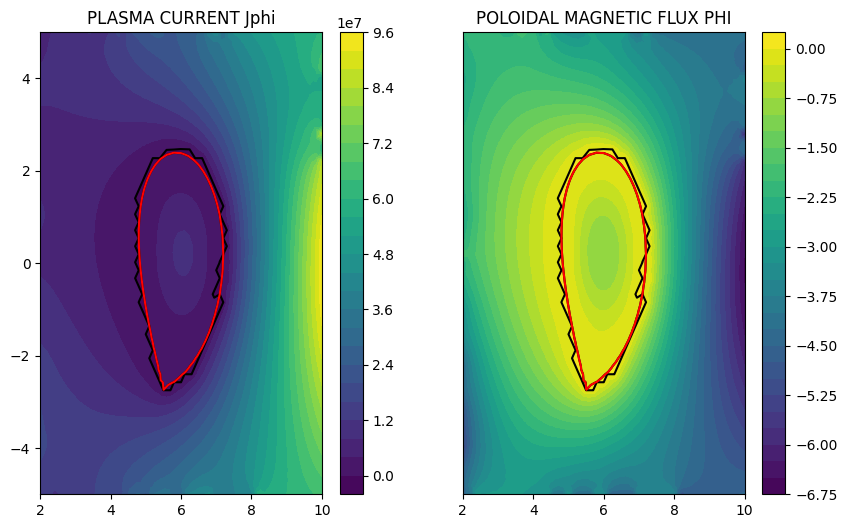

OUTER ITERATION = 1 , INNER ITERATION = 7
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


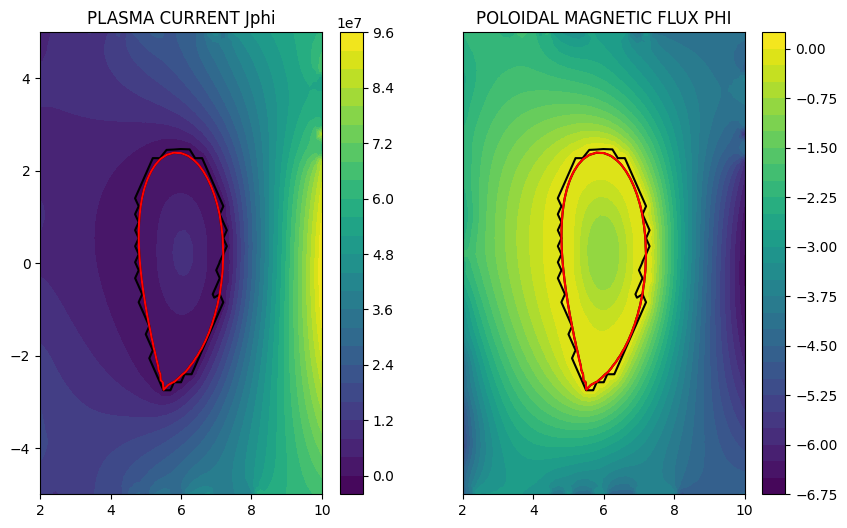

OUTER ITERATION = 2 , INNER ITERATION = 1
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


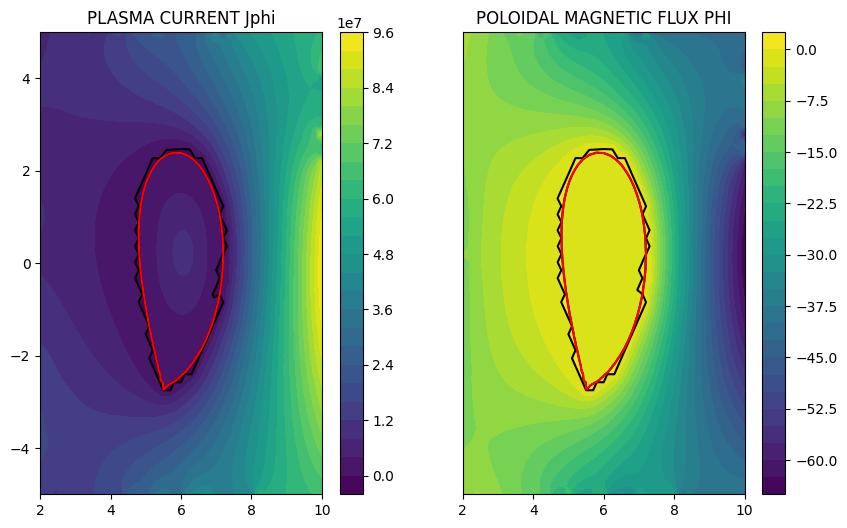

OUTER ITERATION = 2 , INNER ITERATION = 2
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


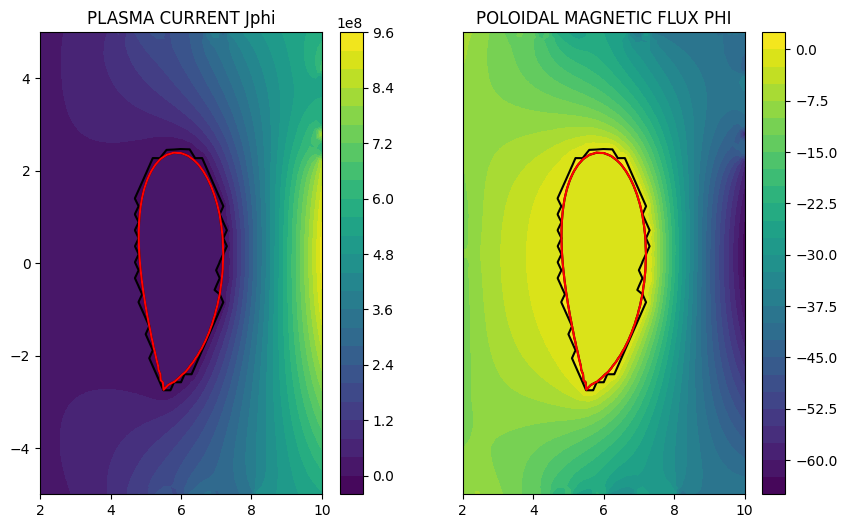

OUTER ITERATION = 2 , INNER ITERATION = 3
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


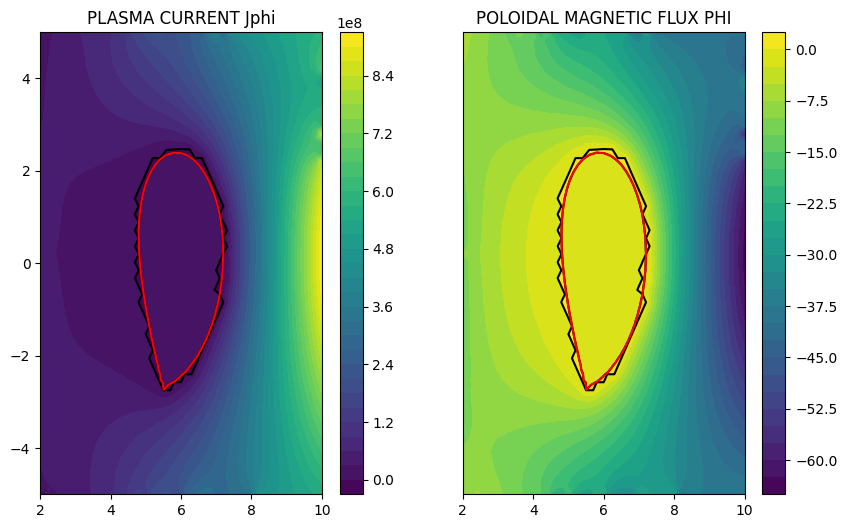

OUTER ITERATION = 2 , INNER ITERATION = 4
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


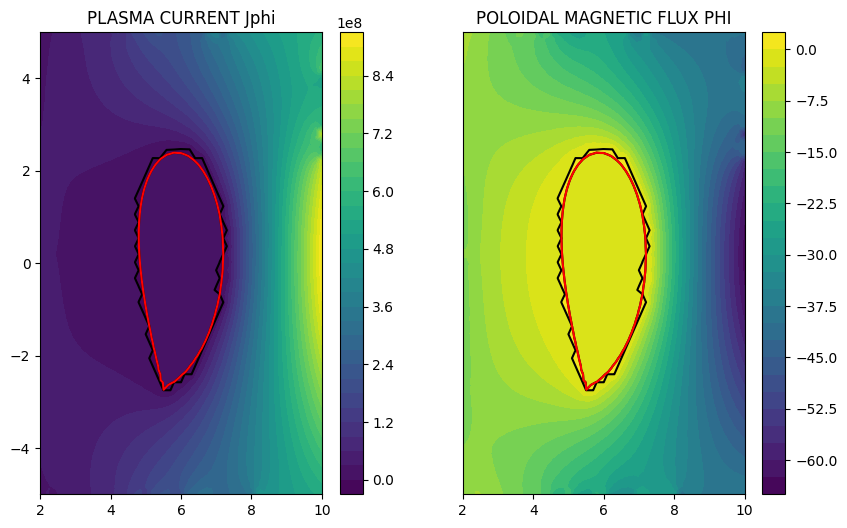

KeyboardInterrupt: 

In [17]:
import sys
sys.path.append('/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/')

from src.GradShafranovCutFEM import *

### LOCATION OF FOLDERS
folder_MESHES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/MESHES/'   # MESHES
folder_CASES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/CASES/'     # CASES

### SELECT MESH FOLDER...
#MESH = 'TS-UNSTRUCTURED_ULTRACOARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE'
#+++MESH = 'TS-UNSTRUCTURED_COARSE-FINE'
MESH = 'TS-UNSTRUCTURED_FINE'
#MESH = 'TS-UNSTRUCTURED_ULTRAFINE'

# ... WITH MESH ELEMENTS:
ElementType = 1     # Element type -> 1: TRIANGLE  ; 2: QUADRILATERAL
ElementOrder = 1    # Element order -> 1: LINEAR  ; 2: QUADRATIC ; 3: CUBIC ...

### SELECT SOLUTION CASE FILE:
#CASE = 'TS-FREE-F4E-LINEAR'          # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND LINEAR PLASMA CURRENT
#CASE = 'TS-FREE-F4E-NONLINEAR'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND NONLINEAR PLASMA CURRENT MODEL
CASE = 'TS-FREE-F4E-PROFILES'        # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD
#CASE = 'TS-FREE-F4E-LINEAR-1W'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, LINEAR PLASMA CURRENT AND FIRST WALL VACUUM VESSEL GEOMETRY  
#CASE = 'TS-FREE-F4E-PROFILES-1W'     # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD AND FIRST WALL VACUUM VESSEL GEOMETRY  

# SELECT ORDER OF NUMERICAL INTEGRATION QUADRATURE
QuadratureOrder = 2

##############################################################

# DECLARE OBJECT PROBLEM 
Problem = GradShafranovCutFEM(folder_MESHES+MESH,folder_CASES+CASE,ElementType,ElementOrder,QuadratureOrder)
Problem.EQUILI()

In [ ]:
TotalCurrent = Problem.ComputeTotalPlasmaCurrent()

TotalCurrent

236233848.2888935

[-2.50069935]
0


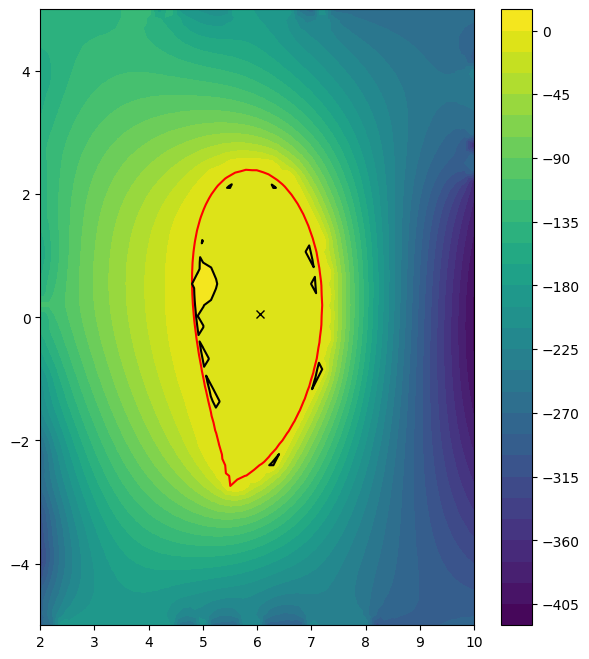

In [ ]:
# Problem.PlotSolution(Problem.PHI)

Xcrit = Problem.ComputeCriticalPHI(Problem.PHI)

print(Problem.PHI_0)
print(Problem.PHI_X)

self = Problem
phi = self.PHI
if len(np.shape(phi)) == 2:
    phi = phi[:,0]
fig, axs = plt.subplots(1, 1, figsize=(7,8))
axs.set_xlim(self.Xmin,self.Xmax)
axs.set_ylim(self.Ymin,self.Ymax)
a = axs.tricontourf(self.X[:,0],self.X[:,1], phi, levels=30)
axs.tricontour(self.X[:,0],self.X[:,1], self.LevelSet, levels=[0], colors = 'red')
axs.tricontour(self.X[:,0],self.X[:,1], phi, levels=[0], colors = 'black')
axs.plot(Xcrit[0],Xcrit[1],'x',color='black')
plt.colorbar(a, ax=axs)
plt.show()

In [ ]:
def ComputeCriticalPHI(self,PHI):
    """ Function which computes the values of PHI at the:
            - MAGNETIC AXIS ->> PHI_0 
            - SEPARATRIX (LAST CLOSED MAGNETIC SURFACE) / SADDLE POINT ->> PHI_X 
    These values are used to NORMALISE PHI. 
    
    THE METHODOLOGY IS THE FOLLOWING:
        1. OBTAIN CANDIDATE POINTS FOR SOLUTIONS OF EQUATION     NORM(GRAD(PHI))^2 = 0
        2. USING A NEWTON METHOD (OR SOLVER), FIND SOLUTION OF    NORM(GRAD(PHI))^2 = 0
        3. CHECK HESSIAN AT SOLUTIONS TO DIFFERENTIATE BETWEEN EXTREMUM AND SADDLE POINT
        
    THIS IS WHAT WE WOULD DO ANALYTICALLY. IN THE NUMERICAL CASE, WE DO:
        1. INTERPOLATE PHI VALUES ON A FINER STRUCTURED MESH USING PHI ON NODES
        2. COMPUTE GRAD(PHI) WITH FINER MESH VALUES USING FINITE DIFFERENCES
        3. OBTAIN CANDIDATE POINTS ON FINER MESH FOR SOLUTIONS OF EQUATION     NORM(GRAD(PHI))^2 = 0
        4. USING A SOLVER, FIND SOLUTION OF  NORM(GRAD(PHI))^2 = 0   BY EVALUATING AN INTERPOLATION OF GRAD(PHI)
        5. CHECK HESSIAN AT SOLUTIONS
        6. INTERPOLATE VALUE OF PHI AT CRITICAL POINT
    """
    
    # 1. INTERPOLATE PHI VALUES ON A FINER STRUCTURED MESH USING PHI ON NODES
    # DEFINE FINER STRUCTURED MESH
    Mr = 60
    Mz = 80
    rfine = np.linspace(self.Xmin, self.Xmax, Mr)
    zfine = np.linspace(self.Ymin, self.Ymax, Mz)
    # INTERPOLATE PHI VALUES
    Rfine, Zfine = np.meshgrid(rfine,zfine)
    PHIfine = griddata((self.X[:,0],self.X[:,1]), PHI.T[0], (Rfine, Zfine), method='cubic')
    
    # 2. COMPUTE NORM(GRAD(PHI)) WITH FINER MESH VALUES USING FINITE DIFFERENCES
    dr = (rfine[-1]-rfine[0])/Mr
    dz = (zfine[-1]-zfine[0])/Mz
    gradPHIfine = np.gradient(PHIfine,dr,dz)
    NORMgradPHIfine = np.zeros(np.shape(gradPHIfine)[1:])
    for i in range(Mr):
        for j in range(Mz):
            NORMgradPHIfine[j,i] = np.linalg.norm(np.array([gradPHIfine[0][j,i],gradPHIfine[1][j,i]])) 
    
    # 3. OBTAIN CANDIDATE POINTS ON FINER MESH FOR SOLUTIONS OF EQUATION     NORM(GRAD(PHI))^2 = 0
    X0 = np.array([self.R0,0])
    
    # 4. USING A GRADIENT DESCENT, FIND SOLUTION OF  NORM(GRAD(PHI))^2 = 0   BY EVALUATING AN INTERPOLATION OF GRAD(PHI)
    # INTERPOLATION OF GRAD(PHI)
    def gradPHI(X,Rfine,Zfine,gradPHIfine):
        dPHIdr = griddata((Rfine.flatten(),Zfine.flatten()), gradPHIfine[0].flatten(), (X[0],X[1]), method='cubic')
        dPHIdz = griddata((Rfine.flatten(),Zfine.flatten()), gradPHIfine[1].flatten(), (X[0],X[1]), method='cubic')
        GRAD = np.array([dPHIdr,dPHIdz])
        return GRAD

    # GRADIENT DESCENT ROUTINE
    def gradient_descent(gradient, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine):
        Xk = np.zeros([itmax,2])
        it = 0; TOL = 1
        Xk[it,:] = X0
        while TOL > tolerance and it < itmax:
            dX = -alpha * gradient(Xk[it,:], Rfine,Zfine,gradPHIfine)
            Xk[it+1,:] = Xk[it,:]+np.flip(dX)
            TOL = np.linalg.norm(Xk[it+1,:]-Xk[it,:])
            it += 1
        return it, TOL, Xk[:it,:] 
    
    # FIND MINIMUM USING GRADIENT DESCENT
    #alpha = 0.2
    #itmax = 50; tolerance = 1e-3
    #it, TOL, Xk = gradient_descent(gradPHI, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine)
    #Xcrit = Xk[-1,:]
    
    sol = optimize.root(gradPHI, X0, args=(Rfine,Zfine,gradPHIfine))
    Xcrit = sol.x
    
    # 5. CHECK HESSIAN AT SOLUTIONS
    def EvaluateHESSIAN(X,gradPHIfine,Rfine,Zfine,dr,dz):
        # compute second derivatives on fine mesh
        dgradPHIdrfine = np.gradient(gradPHIfine[0],dr,dz)
        dgradPHIdzfine = np.gradient(gradPHIfine[1],dr,dz)
        # interpolate HESSIAN components on point 
        dPHIdrdr = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdrfine[0].flatten(), (X[0],X[1]), method='cubic')
        dPHIdzdr = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdrfine[1].flatten(), (X[0],X[1]), method='cubic')
        dPHIdzdz = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdzfine[1].flatten(), (X[0],X[1]), method='cubic')
        if dPHIdrdr*dPHIdzdz-dPHIdzdr**2 > 0:
            return "LOCAL EXTREMUM"
        else:
            return "SADDLE POINT"
        
    nature = EvaluateHESSIAN(Xcrit, gradPHIfine, Rfine, Zfine, dr, dz)
    print(nature)
    
    # 6. INTERPOLATE VALUE OF PHI AT CRITICAL POINT
    def SearchElement(Elements,X,searchelements):
        """ Function which finds the element among the elements list containing the point with coordinates X. """
        for elem in searchelements:
            Xe = Elements[elem].Xe
            # Calculate the cross products (c1, c2, c3) for the point relative to each edge of the triangle
            c1 = (Xe[1,0]-Xe[0,0])*(X[1]-Xe[0,1])-(Xe[1,1]-Xe[0,1])*(X[0]-Xe[0,0])
            c2 = (Xe[2,0]-Xe[1,0])*(X[1]-Xe[1,1])-(Xe[2,1]-Xe[1,1])*(X[0]-Xe[1,0])
            c3 = (Xe[0,0]-Xe[2,0])*(X[1]-Xe[2,1])-(Xe[0,1]-Xe[2,1])*(X[0]-Xe[2,0])
            if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0): # INSIDE TRIANGLE
                break
        return elem
    
    if nature == "LOCAL EXTREMUM":
        # FOR THE MAGNETIC AXIS VALUE PHI_0, THE LOCAL EXTREMUM SHOULD LIE INSIDE THE PLASMA REGION
        elem = SearchElement(self.Elements,Xcrit,self.PlasmaElems)
        self.PHI_0 = self.Elements[elem].ElementalInterpolation(Xcrit,PHI[self.Elements[elem].Te])
        self.PHI_X = 0
    else:
        elem = SearchElement(self.Elements,Xcrit,self.VacuumElems)
        self.PHI_X = self.Elements[elem].ElementalInterpolation(Xcrit,PHI[self.Elements[elem].Te])
        self.PHI_0 = 0
        
    return Xcrit, self.PHI_0, self.PHI_X

Xcrit, PHI_0, PHI_X = ComputeCriticalPHI(self,self.PHI)


LOCAL EXTREMUM


In [ ]:
PHI_0

array([-2.50069935])